In [1]:
# importo le librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, Input
from tensorflow.keras.optimizers import Adam

# SET DEL SEED PER OTTENERE GLI STESSI RISULTATI
SEED = 42
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)
np.random.seed(SEED)

In [36]:
def load_dataset():
  # carico i dati in formato CSV
  CO2 = pd.read_csv("/content/2024-06-24_11_10_influxdb_data.csv", header=3)
  Noise = pd.read_csv("/content/2024-06-24_11_11_influxdb_data.csv", header=3)

  return CO2, Noise

In [37]:
# Carica i dati dal dataset
CO2, Noise = load_dataset()

# DIRECTED PROBLEM
X = np.array(CO2[['_value']])
y = np.array(Noise['_value'])

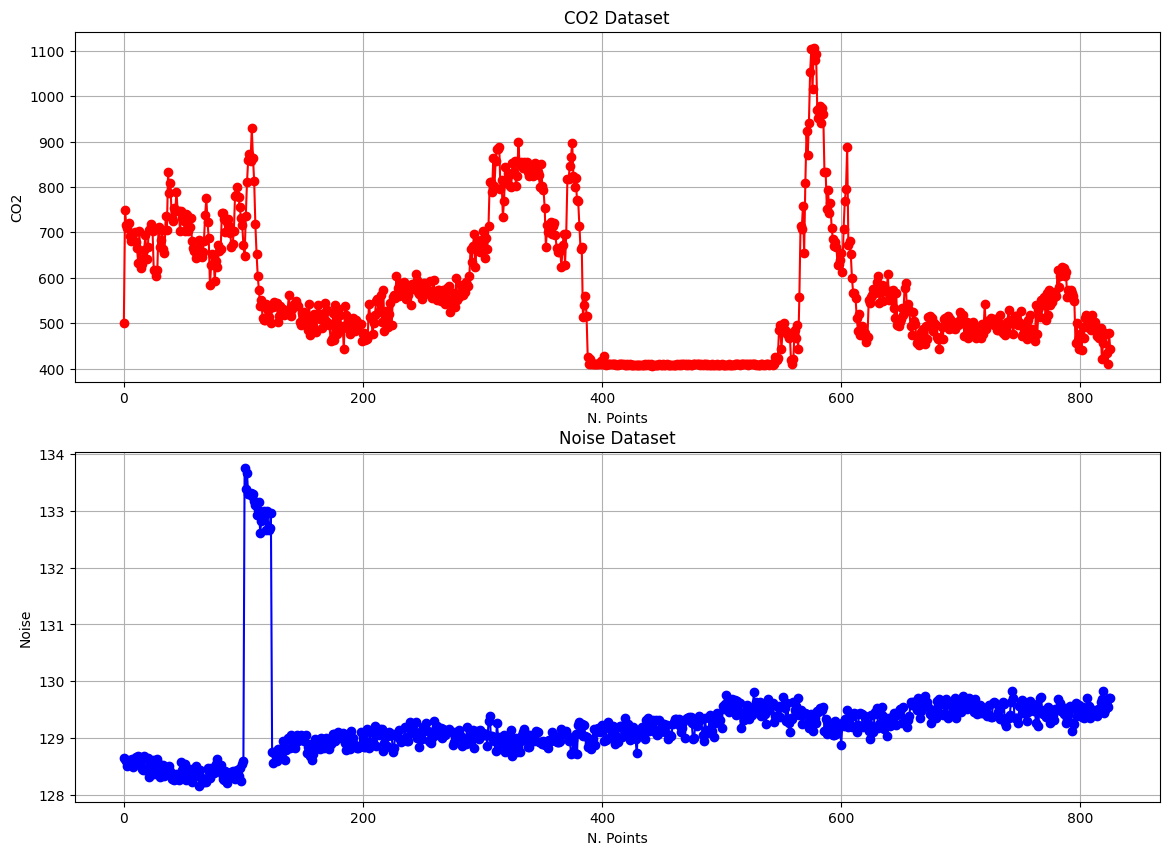

In [38]:
# Plot dataset
plt.figure(figsize=(14,10))

plt.subplot(2, 1, 1)
plt.title('CO2 Dataset')
plt.plot(X, 'ro-')
plt.xlabel('N. Points')
plt.ylabel('CO2')
plt.grid()

plt.subplot(2, 1, 2)
plt.title('Noise Dataset')
plt.plot(y, 'bo-')
plt.xlabel('N. Points')
plt.ylabel('Noise')
plt.grid()

plt.savefig('/content/dataset_1.png')
plt.show()

In [39]:
# Creiamo sequenze di dati per LSTM
def create_sequences(X, y, seq_length=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 10  # Lunghezza delle sequenze
X_seq, y_seq = create_sequences(X, y, seq_length)

In [40]:
# NON SEPARARE IL DATASET RANDOMICAMENTE (SERIE TEMPORALI)
N = len(X_seq)

train_samples = int(0.6*N)
valid_samples = int(0.2*N)
test_samples = N - (train_samples + valid_samples)

# split and reshape input and label data
X_train, y_train = X_seq[: train_samples], y_seq[: train_samples]
X_val, y_val = X_seq[train_samples : -test_samples], y_seq[train_samples : -test_samples]
X_test, y_test = X_seq[-test_samples :], y_seq[-test_samples :]

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_13 (LSTM)              (None, 10, 50)            20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
49/49 [==============================] - 5s 28ms/step - loss: 14835.8477 - mean_absolute_error: 88.8688 - val_loss: 3126.7009 - val_mean

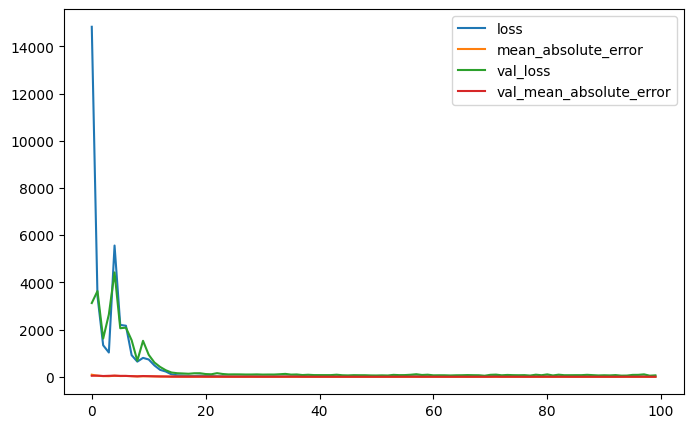

In [41]:
# Aggiusto la forma dei dati per l'input della LSTM
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Crea il modello LSTM
model_1 = Sequential()
model_1.add(Input(shape=(seq_length, 1), name='input')),
#model_1.add(Conv1D(filters=16, kernel_size=2, activation='linear'))
model_1.add(LSTM(50, return_sequences=True, activation='linear'))
model_1.add(LSTM(50, return_sequences=True, activation='linear'))
model_1.add(LSTM(50, activation='linear'))
#model_1.add(Dense(10, activation='linear'))
model_1.add(Dense(1))

# Compila il modello
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics='mean_absolute_error')

# Summary del modello
model_1.summary()

# Addestra il modello
history = model_1.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=10)

# History plot
history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(8, 5))
plt.show()

In [42]:
# Valuta il modello
loss = model_1.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Data: {loss[0]}')
print(f'Mean Absolute Error on Test Data: {loss[1]}')

# Fai delle previsioni
y_pred = model_1.predict(X_test)

6/6 [==============================] - 0s 6ms/step - loss: 6.9264 - mean_absolute_error: 2.0551
Mean Squared Error on Test Data: 6.9264349937438965
Mean Absolute Error on Test Data: 2.0550684928894043


6/6 [==============================] - 0s 7ms/step


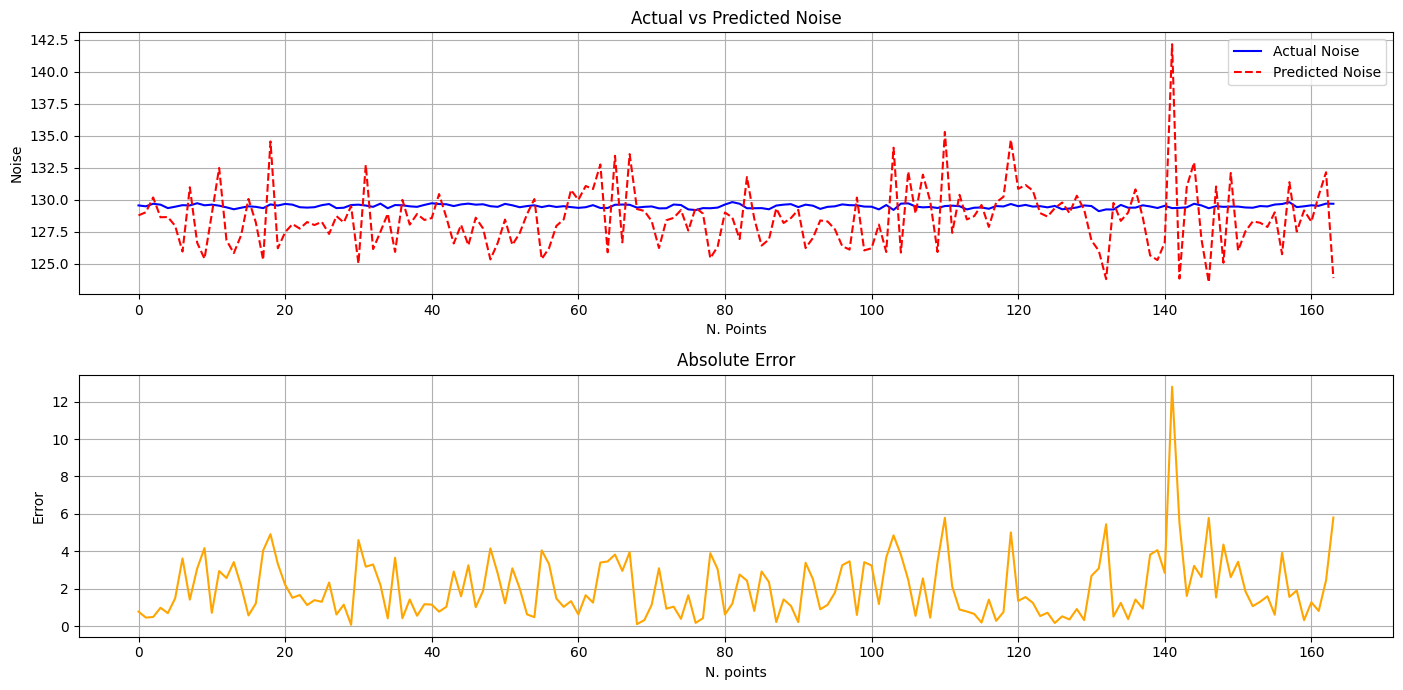

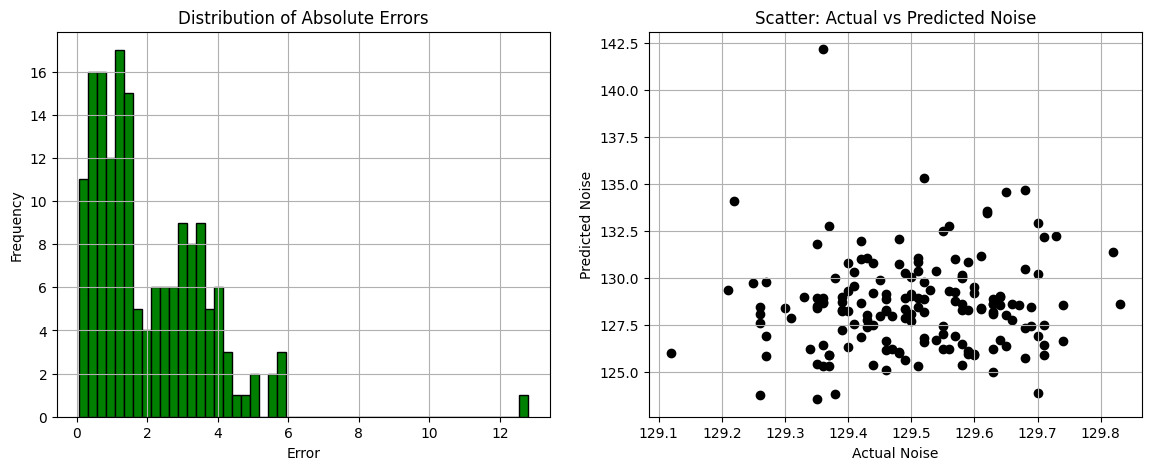

In [43]:
# Visualizza i risultati
plt.figure(figsize=(14, 7))

# Plot a linea
plt.subplot(2, 1, 1)
plt.plot(y_test, color='blue', label='Actual Noise')
plt.plot(y_pred, color='red', label='Predicted Noise', linestyle='--')
plt.title('Actual vs Predicted Noise')
plt.xlabel('N. Points')
plt.ylabel('Noise')
plt.legend()
plt.grid()

# Plot dell'errore assoluto
plt.subplot(2, 1, 2)
absolute_error = np.abs(y_test - y_pred.flatten())
plt.plot(absolute_error, color='orange')
plt.title('Absolute Error')
plt.xlabel('N. points')
plt.ylabel('Error')
plt.grid()

plt.tight_layout()
plt.savefig('/content/results_1.png')
plt.show()

plt.figure(figsize=(14, 5))

# Plot della distribuzione degli errori
plt.subplot(1, 2, 1)
plt.hist(absolute_error, bins=50, color='green', edgecolor='black')
plt.title('Distribution of Absolute Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

# Visualizza i risultati in uno scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, color='black')
plt.title('Scatter: Actual vs Predicted Noise')
plt.xlabel('Actual Noise')
plt.ylabel('Predicted Noise')
plt.grid()

plt.savefig('/content/distribution_1.png')
plt.show()

In [44]:
# ---------------------------------------------------------------------

# INVERTED PROBLEM
X = np.array(Noise[['_value']])
y = np.array(CO2['_value'])

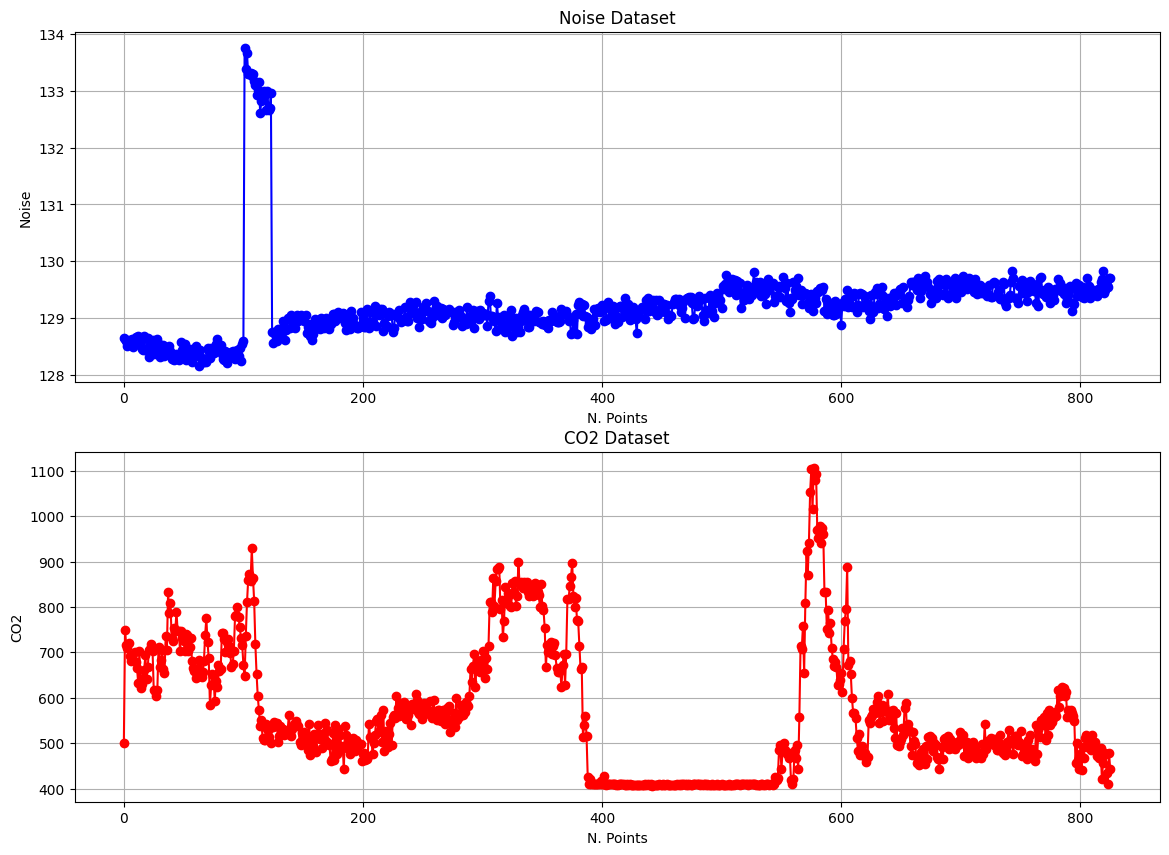

In [45]:
# Plot dataset
plt.figure(figsize=(14,10))

plt.subplot(2, 1, 1)
plt.title('Noise Dataset')
plt.plot(X, 'bo-')
plt.xlabel('N. Points')
plt.ylabel('Noise')
plt.grid()

plt.subplot(2, 1, 2)
plt.title('CO2 Dataset')
plt.plot(y, 'ro-')
plt.xlabel('N. Points')
plt.ylabel('CO2')
plt.grid()

plt.savefig('/content/dataset_2.png')
plt.show()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_16 (LSTM)              (None, 10, 50)            20200     
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
49/49 [==============================] - 6s 28ms/step - loss: 165093.7969 - mean_absolute_error: 341.4872 - val_loss: 34454.7031 - val_m

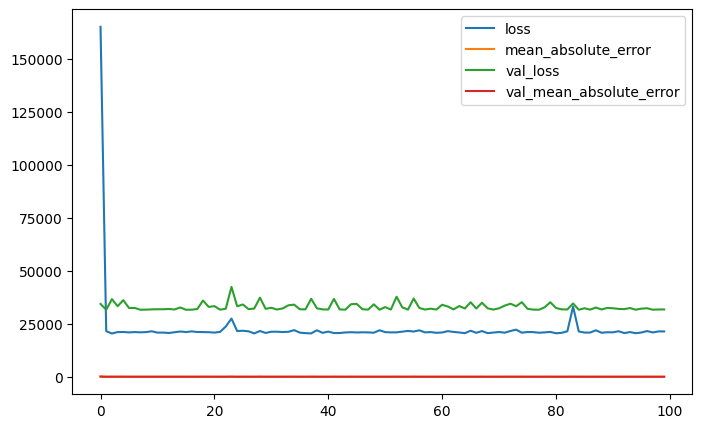

In [46]:
seq_length = 10  # Lunghezza delle sequenze
X_seq, y_seq = create_sequences(X, y, seq_length)

# NON SEPARARE IL DATASET RANDOMICAMENTE (SERIE TEMPORALI)
N = len(X_seq)

train_samples = int(0.6*N)
valid_samples = int(0.2*N)
test_samples = N - (train_samples + valid_samples)

# split and reshape input and label data
X_train, y_train = X_seq[: train_samples], y_seq[: train_samples]
X_val, y_val = X_seq[train_samples : -test_samples], y_seq[train_samples : -test_samples]
X_test, y_test = X_seq[-test_samples :], y_seq[-test_samples :]

# Aggiusta la forma dei dati per l'input nella LSTM
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Crea il modello LSTM
model_2 = Sequential()
model_2.add(Input(shape=(seq_length, 1), name='input')),
#model_2.add(Conv1D(filters=16, kernel_size=2, activation='linear'))
model_2.add(LSTM(50, return_sequences=True, activation='linear'))
model_2.add(LSTM(50, return_sequences=True, activation='linear'))
model_2.add(LSTM(50, activation='linear'))
#model_2.add(Dense(10, activation='linear'))
model_2.add(Dense(1))

# Compila il modello
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics='mean_absolute_error')

# Summary del modello
model_2.summary()

# Addestra il modello
history = model_2.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=10)

# History plot
history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(8, 5))
plt.show()

In [47]:
# Valuta il modello
loss = model_2.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Data: {loss[0]}')
print(f'Mean Absolute Error on Test Data: {loss[1]}')

# Fai delle previsioni
y_pred = model_2.predict(X_test)

6/6 [==============================] - 0s 6ms/step - loss: 7092.3066 - mean_absolute_error: 77.7469
Mean Squared Error on Test Data: 7092.306640625
Mean Absolute Error on Test Data: 77.74686431884766
6/6 [==============================] - 0s 5ms/step


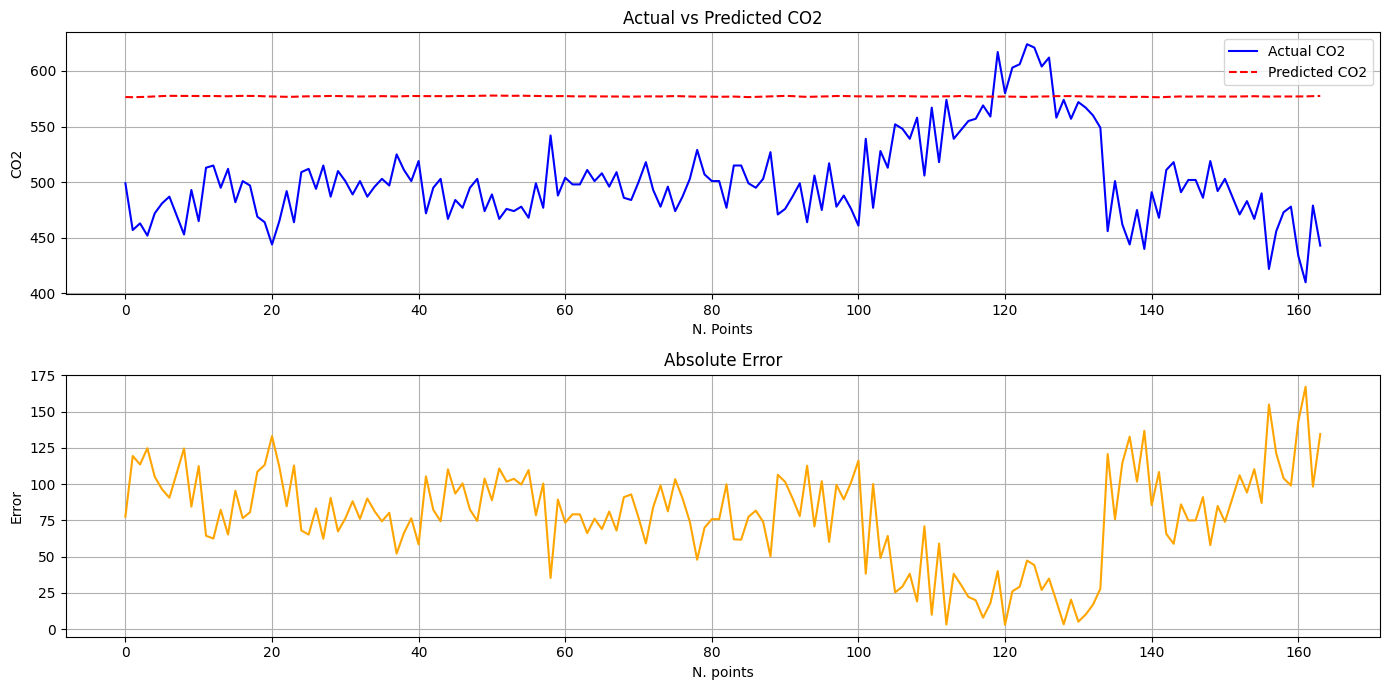

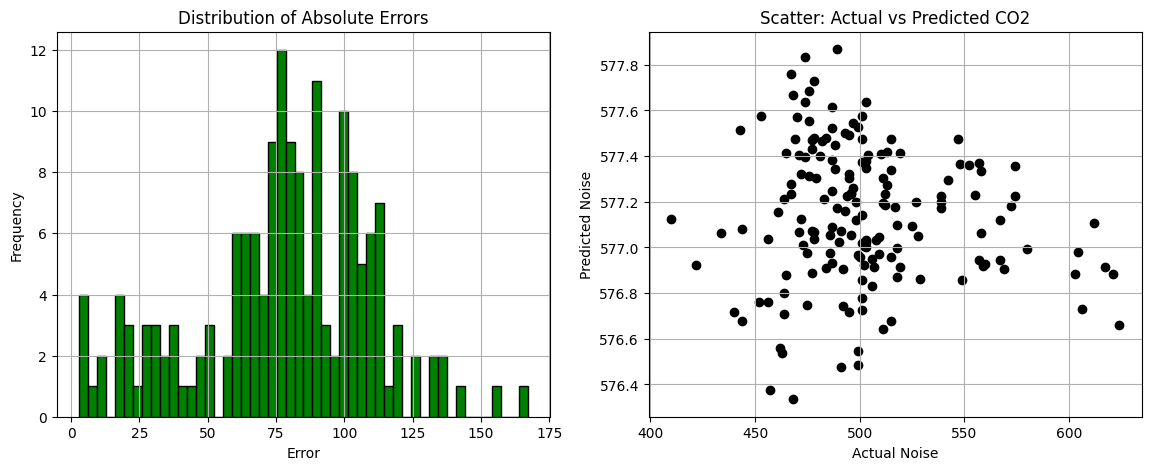

In [48]:
# Visualizza i risultati
plt.figure(figsize=(14, 7))

# Plot a linea
plt.subplot(2, 1, 1)
plt.plot(y_test, color='blue', label='Actual CO2')
plt.plot(y_pred, color='red', label='Predicted CO2', linestyle='--')
plt.title('Actual vs Predicted CO2')
plt.xlabel('N. Points')
plt.ylabel('CO2')
plt.legend()
plt.grid()

# Plot dell'errore assoluto
plt.subplot(2, 1, 2)
absolute_error = np.abs(y_test - y_pred.flatten())
plt.plot(absolute_error, color='orange')
plt.title('Absolute Error')
plt.xlabel('N. points')
plt.ylabel('Error')
plt.grid()

plt.tight_layout()
plt.savefig('/content/results_2.png')
plt.show()

# Plot della distribuzione degli errori
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(absolute_error, bins=50, color='green', edgecolor='black')
plt.title('Distribution of Absolute Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

# Visualizza i risultati in uno scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, color='black')
plt.title('Scatter: Actual vs Predicted CO2')
plt.xlabel('Actual Noise')
plt.ylabel('Predicted Noise')
plt.grid()

plt.savefig('/content/distribution_2.png')
plt.show()